In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Multivariate analysis

### Define some constants

In [36]:
START_DATE = '2022-11-03'
END_DATE = '2023-06-06'

### Read dataset

In [29]:
df_pm25     = pd.read_csv('../resources/dataset/board20/s250.csv') #mu_g/m^3
df_temp     = pd.read_csv('../resources/dataset/board20_temp/s258.csv')  #°C
df_rh       = pd.read_csv('../resources/dataset/board20_rh/s259.csv')  #%
df_press    = pd.read_csv('../resources/dataset/board20_pres/s260.csv')  #hpa

df_press.drop_duplicates(inplace=True)
df_rh.drop_duplicates(inplace=True)
df_temp.drop_duplicates(inplace=True)
df_pm25.drop_duplicates(inplace=True)

df_pm25.timestamp   = pd.to_datetime(df_pm25.timestamp)
df_temp.timestamp   = pd.to_datetime(df_temp.timestamp)
df_rh.timestamp     = pd.to_datetime(df_rh.timestamp)
df_press.timestamp  = pd.to_datetime(df_press.timestamp)

In [37]:
mask_pm25   = (df_pm25['timestamp'] >= START_DATE) & (df_pm25['timestamp'] <= END_DATE)
mask_temp   = (df_temp['timestamp'] >= START_DATE) & (df_temp['timestamp'] <= END_DATE)
mask_rh     = (df_rh['timestamp'] >= START_DATE) & (df_rh['timestamp'] <= END_DATE)
mask_press  = (df_press['timestamp'] >= START_DATE) & (df_press['timestamp'] <= END_DATE)

df_pm25_filtered    = df_pm25.loc[mask_pm25]
df_temp_filtered    = df_temp.loc[mask_temp]
df_rh_filtered      = df_rh.loc[mask_rh]
df_press_filtered   = df_press.loc[mask_press]

In [38]:
df_pm25_aggr    = df_pm25_filtered.groupby(pd.Grouper(key='timestamp', freq='min')).mean().reset_index()
df_temp_aggr    = df_temp_filtered.groupby(pd.Grouper(key='timestamp', freq='min')).mean().reset_index()
df_rh_aggr      = df_rh_filtered.groupby(pd.Grouper(key='timestamp', freq='min')).mean().reset_index()
df_press_aggr   = df_press_filtered.groupby(pd.Grouper(key='timestamp', freq='min')).mean().reset_index()

### Obtain a unique dataset

Manage null points

In [6]:
df_pm25_aggr.isna().sum()

timestamp       0
data         9088
dtype: int64

In [40]:
df_pm25_aggr.dropna(inplace=True)
df_temp_aggr.dropna(inplace=True)
df_rh_aggr.dropna(inplace=True)
df_press_aggr.dropna(inplace=True)

In [8]:
print(len(df_pm25_aggr), 'pm25')
print(len(df_temp_aggr), 'temp')
print(len(df_rh_aggr), 'rh')
print(len(df_press_aggr), 'press')

70698 pm25
70652 temp
70651 rh
70689 press


In [53]:
print(min(df_pm25_aggr.timestamp), max(df_pm25_aggr.timestamp))
print(min(df_temp_aggr.timestamp), max(df_temp_aggr.timestamp))
print(min(df_rh_aggr.timestamp), max(df_rh_aggr.timestamp))
print(min(df_press_aggr.timestamp), max(df_press_aggr.timestamp))

2022-11-04 14:15:00 2023-04-08 02:57:00
2022-11-04 14:15:00 2023-04-08 02:57:00
2022-11-04 14:15:00 2023-04-08 02:57:00
2022-11-04 14:15:00 2023-04-08 00:42:00


Filter by date in order to have all datasets with the same size

In [54]:
df_pm25_aggr_2 = df_pm25_aggr.loc[(df_pm25_aggr['timestamp'] < '2023-04-07')]

In [11]:
print(min(df_pm25_aggr_2.timestamp), max(df_pm25_aggr_2.timestamp))
print(len(df_pm25_aggr_2))

2022-11-04 14:15:00 2022-12-29 23:59:00
70697


In [12]:
df_rh_aggr.loc[(df_rh_aggr.timestamp == '2022-11-04')]

,timestamp,data


I choose to make a unique dataset based on the longest not null sequence of data (i.e: PM25)

In [56]:
df_completed = pd.DataFrame(columns=['timestamp', 'pm25', 'temp', 'rh', 'press'])
df_completed['timestamp']   = df_pm25_aggr['timestamp'] # df_pm25_aggr_2['timestamp']
df_completed['pm25']        = df_pm25_aggr['data'] # df_pm25_aggr_2['data']
df_completed['temp']        = df_temp_aggr['data']
df_completed['rh']          = df_rh_aggr['data']
df_completed['press']       = df_press_aggr['data']

In [43]:
df_completed.head()

,timestamp,pm25,temp,rh,press
0,2022-11-04 14:15:00,7.000000,20.500000,53.340000,974.712050
1,2022-11-04 14:16:00,6.352941,20.500000,53.607143,974.714567
2,2022-11-04 14:17:00,3.757576,20.503846,53.965385,974.734150
3,2022-11-04 14:18:00,7.500000,20.433333,50.733333,974.637550
8,2022-11-04 14:23:00,2.000000,19.911111,55.933333,974.741975


In [15]:
df_completed.isna().any(axis=0).sort_values(ascending=False)

temp          True
rh            True
press         True
timestamp    False
pm25         False
dtype: bool

In [16]:
df_completed.isna().sum()

timestamp     0
pm25          0
temp         45
rh           46
press         8
dtype: int64

In [17]:
df_completed[df_completed['press'].isna()].head()

,timestamp,pm25,temp,rh,press
38954,2022-12-01 15:29:00,6.0,NaN,NaN,NaN
40875,2022-12-02 23:30:00,17.5,11.3,62.2,NaN
50481,2022-12-09 15:36:00,14.0,9.6,64.5,NaN
53273,2022-12-11 14:08:00,7.0,11.8,48.1,NaN
59626,2022-12-16 00:01:00,15.0,NaN,NaN,NaN


## Correlation analysis

### Keep data aggregate by minutes

In [57]:
df_completed_no_null = df_completed.dropna()

In [58]:
pearson_matrix = df_completed_no_null.corr()
spearman_matrix = df_completed_no_null.corr(method='spearman')

pearson_ranges = pearson_matrix['pm25'].drop('pm25')
spearman_ranges = spearman_matrix['pm25'].drop('pm25')
print('MAX:', max(pearson_ranges), max(spearman_ranges))
print('MIN:', min(pearson_ranges), min(spearman_ranges))

MAX: 0.33476443434837033 0.310918274711213
MIN: -0.21117572505975185 -0.20922203147537644


It's possibile to see that Pearson correlation produces higher results in term of correlation

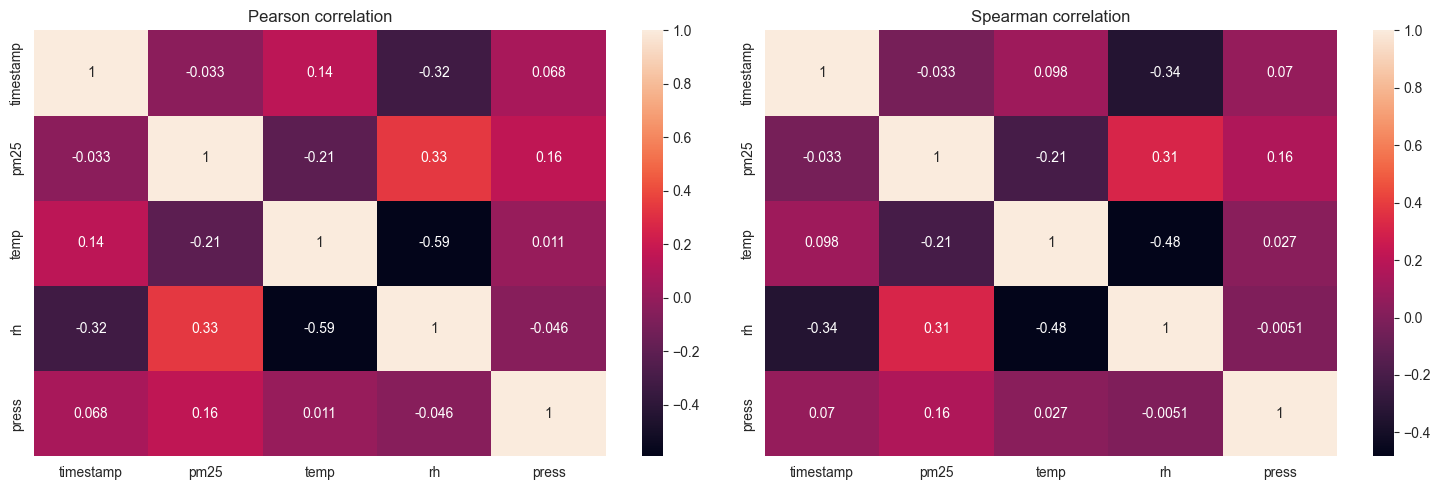

In [59]:
_, ax = plt.subplots(1,2, figsize = (15,5))

sns.heatmap(pearson_matrix, ax=ax[0], annot=True)
sns.heatmap(spearman_matrix, ax=ax[1], annot=True)
ax[0].set_title('Pearson correlation')
ax[1].set_title('Spearman correlation')
plt.tight_layout()
plt.show()

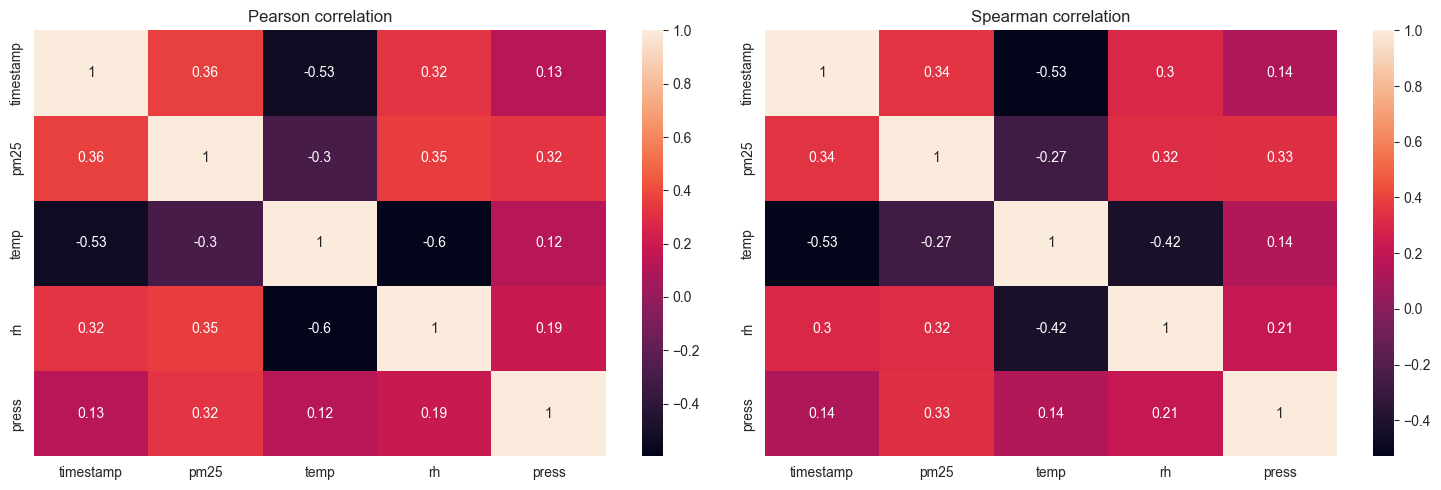

In [61]:
_, ax = plt.subplots(1,2, figsize = (15,5))

sns.heatmap(pearson_matrix, ax=ax[0], annot=True)
sns.heatmap(spearman_matrix, ax=ax[1], annot=True)
ax[0].set_title('Pearson correlation')
ax[1].set_title('Spearman correlation')

plt.tight_layout()
plt.show()

- rispetto alla features PM25 i valori di Pearson sono circa su un +-0.3 (un 30% di correlazione negativa o positiva).
- il più correllato è il timestamp: in base alla stagionalità i valori di PM25 variano (come testimoniato anche da Pietro)
- anche l'umidità segue di conseguenza in base al timestamp (alla stagione)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


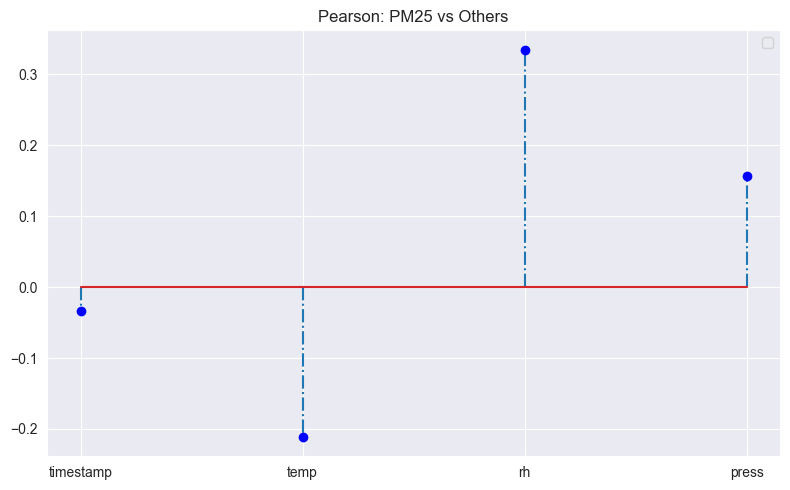

In [60]:
attributes = ['timestamp', 'temp', 'rh', 'press']
pm25_correlations = pearson_matrix['pm25']

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.stem(attributes,  pm25_correlations[attributes], linefmt='-.', markerfmt='bo')
#ax.axhline(y=0.1, color='brown', linestyle='--', label='min correlation')

ax.tick_params(axis='x', labelrotation = 0)
ax.set_title("Pearson: PM25 vs Others")
ax.grid()
ax.legend()

plt.grid()
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


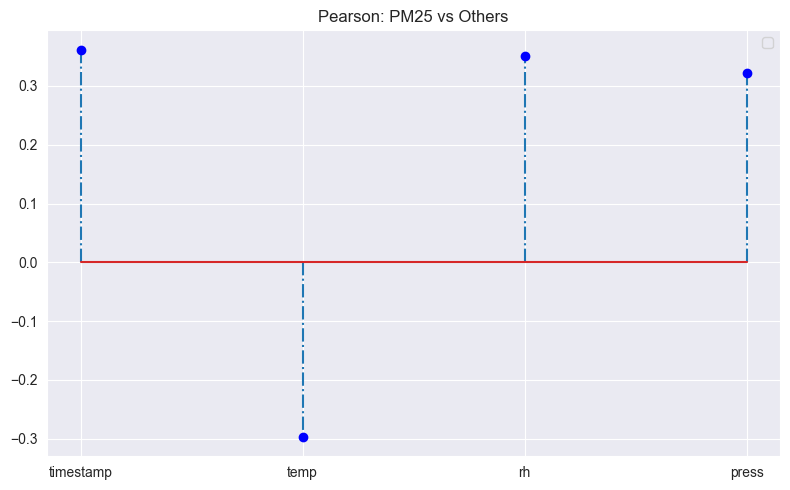

In [63]:
attributes = ['timestamp', 'temp', 'rh', 'press']
pm25_correlations = pearson_matrix['pm25']

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.stem(attributes,  pm25_correlations[attributes], linefmt='-.', markerfmt='bo')
#ax.axhline(y=0.1, color='brown', linestyle='--', label='min correlation')

ax.tick_params(axis='x', labelrotation = 0)
ax.set_title("Pearson: PM25 vs Others")
ax.grid()
ax.legend()

plt.grid()
plt.tight_layout()
plt.show()

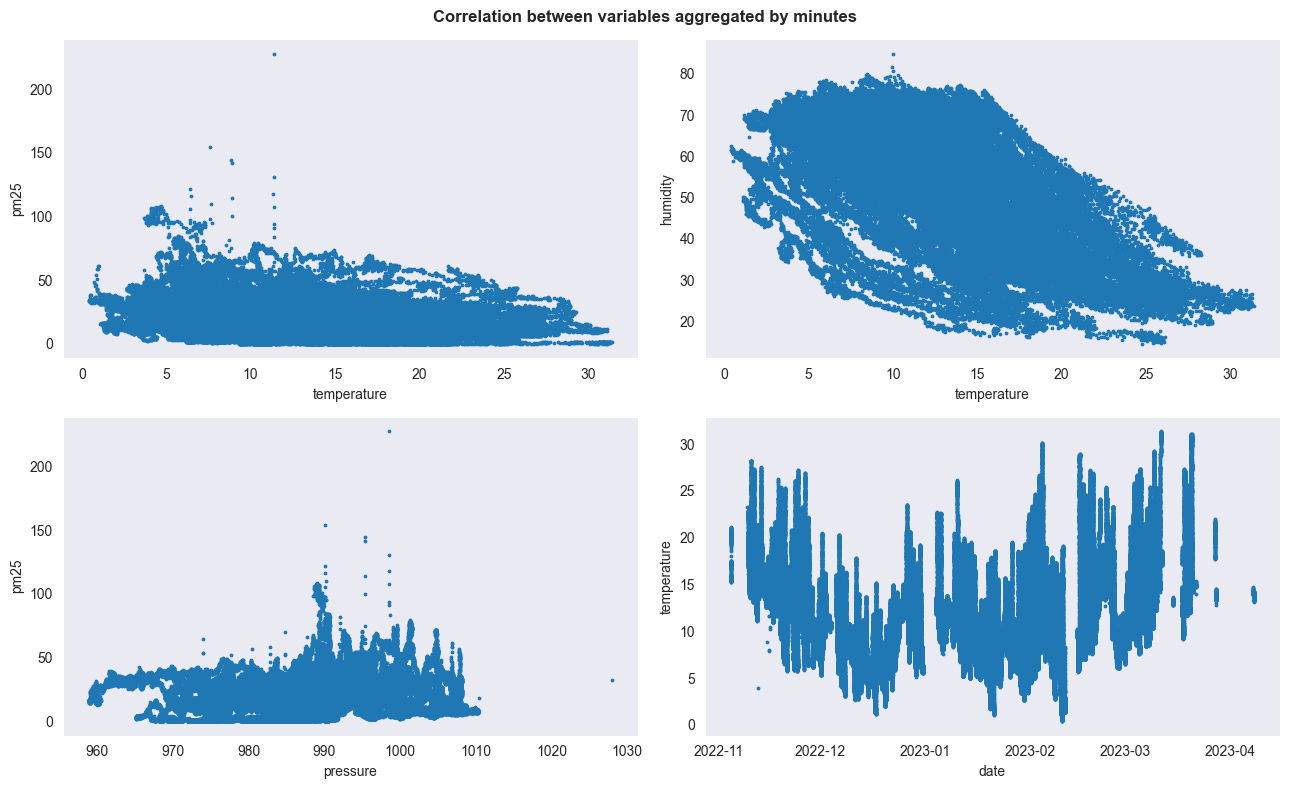

In [67]:
_, ax = plt.subplots(2,2, figsize=(13, 8))

ax[0][0].scatter(df_completed_no_null['temp'], df_completed_no_null['pm25'], s=3)
ax[0][0].grid()
ax[0][0].set_xlabel('temperature')
ax[0][0].set_ylabel('pm25')
ax[0][1].scatter(df_completed_no_null['temp'], df_completed_no_null['rh'], s=3)
ax[0][1].grid()
ax[0][1].set_xlabel('temperature')
ax[0][1].set_ylabel('humidity')
ax[1][0].scatter(df_completed_no_null['press'], df_completed_no_null['pm25'], s=3)
ax[1][0].grid()
ax[1][0].set_xlabel('pressure')
ax[1][0].set_ylabel('pm25')
ax[1][1].scatter(df_completed_no_null['timestamp'], df_completed_no_null['temp'], s=3)
ax[1][1].grid()
ax[1][1].set_xlabel('date')
ax[1][1].set_ylabel('temperature')
fig.suptitle('Correlation between variables aggregated by minutes', fontweight='bold')
plt.tight_layout()
plt.show()

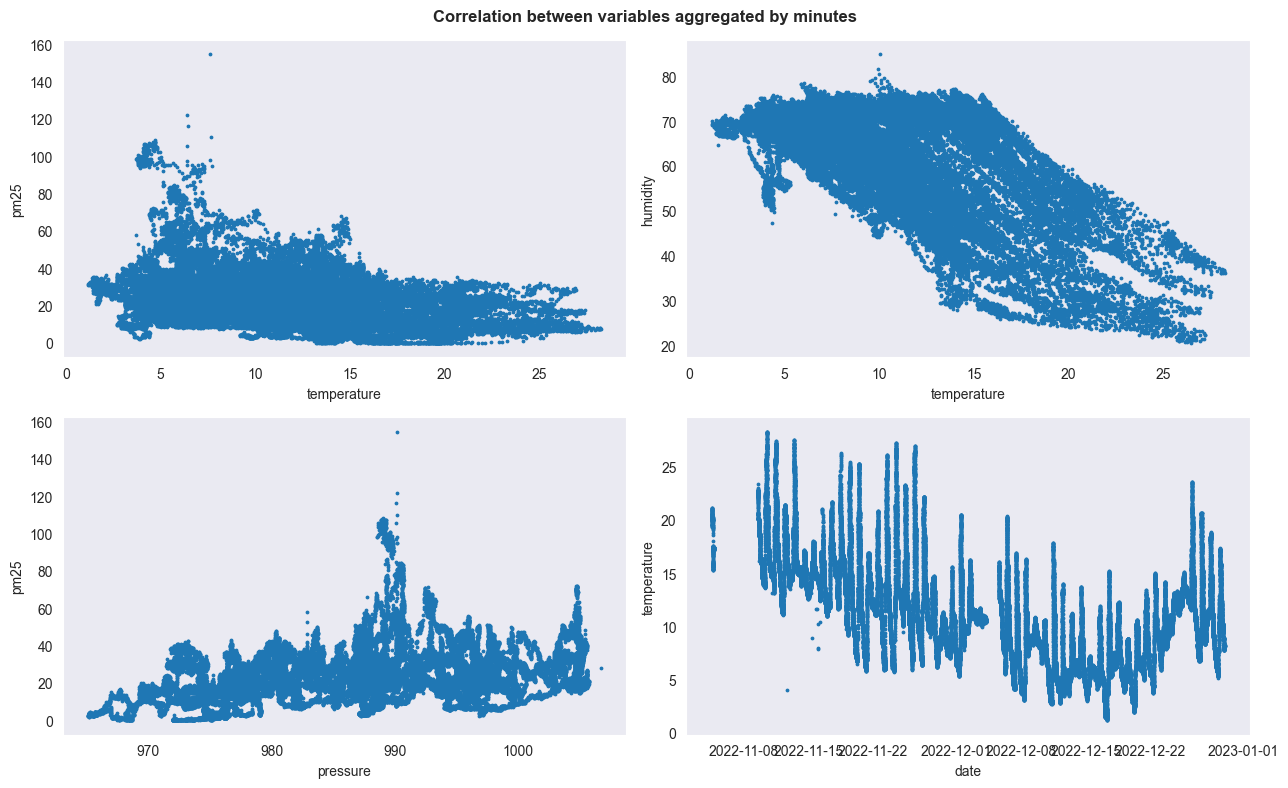

In [20]:
fig, ax = plt.subplots(2,2, figsize=(13, 8))

ax[0][0].scatter(df_completed_no_null['temp'], df_completed_no_null['pm25'], s=3)
ax[0][0].grid()
ax[0][0].set_xlabel('temperature')
ax[0][0].set_ylabel('pm25')
#ax[0][0].text(22, 150, r'correlation: $' + str(round(pearson_matrix['temp']['pm25'], 3)) + '$', fontsize=9,
#              bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 2})

ax[0][1].scatter(df_completed_no_null['temp'], df_completed_no_null['rh'], s=3)
ax[0][1].grid()
ax[0][1].set_xlabel('temperature')
ax[0][1].set_ylabel('humidity')
#ax[0][1].text(20, 3, r'correlation: $' + str(round(pearson_matrix['rh']['temp'], 3)) + '$', fontsize=9,
#              bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 2})

ax[1][0].scatter(df_completed_no_null['press'], df_completed_no_null['pm25'], s=3)
ax[1][0].grid()
ax[1][0].set_xlabel('pressure')
ax[1][0].set_ylabel('pm25')
#ax[1][0].text(0, 0, r'correlation: $' + str(round(pearson_matrix['press']['pm25'], 3)) + '$', fontsize=9)

ax[1][1].scatter(df_completed_no_null['timestamp'], df_completed_no_null['temp'], s=3)
ax[1][1].grid()
ax[1][1].set_xlabel('date')
ax[1][1].set_ylabel('temperature')
#ax[1][1].text(1, 1, r'correlation: $' + str(round(pearson_matrix['timestamp']['temp'], 3)) + '$', fontsize=9)

fig.suptitle('Correlation between variables aggregated by minutes', fontweight='bold')
plt.tight_layout()
plt.show()

### Try to aggregate by hours

In [61]:
df_pm25_aggr_h    = df_pm25_aggr.groupby(pd.Grouper(key='timestamp', freq='H')).mean().reset_index() # df_pm25_aggr_2.groupby(pd.Grouper(key='timestamp', freq='H')).mean().reset_index()
df_temp_aggr_h    = df_temp_aggr.groupby(pd.Grouper(key='timestamp', freq='H')).mean().reset_index()
df_rh_aggr_h      = df_rh_aggr.groupby(pd.Grouper(key='timestamp', freq='H')).mean().reset_index()
df_press_aggr_h   = df_press_aggr.groupby(pd.Grouper(key='timestamp', freq='H')).mean().reset_index()

In [62]:
df_pm25_aggr_h.dropna(inplace=True)
df_temp_aggr_h.dropna(inplace=True)
df_rh_aggr_h.dropna(inplace=True)
df_press_aggr_h.dropna(inplace=True)

In [63]:
print(len(df_pm25_aggr_h), 'pm25')
print(len(df_temp_aggr_h), 'temp')
print(len(df_rh_aggr_h), 'rh')
print(len(df_press_aggr_h), 'press')

2829 pm25
2829 temp
2829 rh
2808 press


In [64]:
df_completed_h = pd.DataFrame(columns=['timestamp', 'pm25', 'temp', 'rh', 'press'])
df_completed_h['timestamp']   = df_pm25_aggr_h['timestamp']
df_completed_h['pm25']        = df_pm25_aggr_h['data']
df_completed_h['temp']        = df_temp_aggr_h['data']
df_completed_h['rh']          = df_rh_aggr_h['data']
df_completed_h['press']       = df_press_aggr_h['data']

In [119]:
df_completed_h.isna().sum()

timestamp    0
pm25         0
temp         0
rh           0
press        0
dtype: int64

In [65]:
pearson_matrix = df_completed_h.corr()
spearman_matrix = df_completed_h.corr(method='spearman')

pearson_ranges = pearson_matrix['pm25'].drop('pm25')
spearman_ranges = spearman_matrix['pm25'].drop('pm25')
print('MAX:', max(pearson_ranges), max(spearman_ranges))
print('MIN:', min(pearson_ranges), min(spearman_ranges))

MAX: 0.3542750296752203 0.3251244951126832
MIN: -0.22379676348594468 -0.22115642322112042


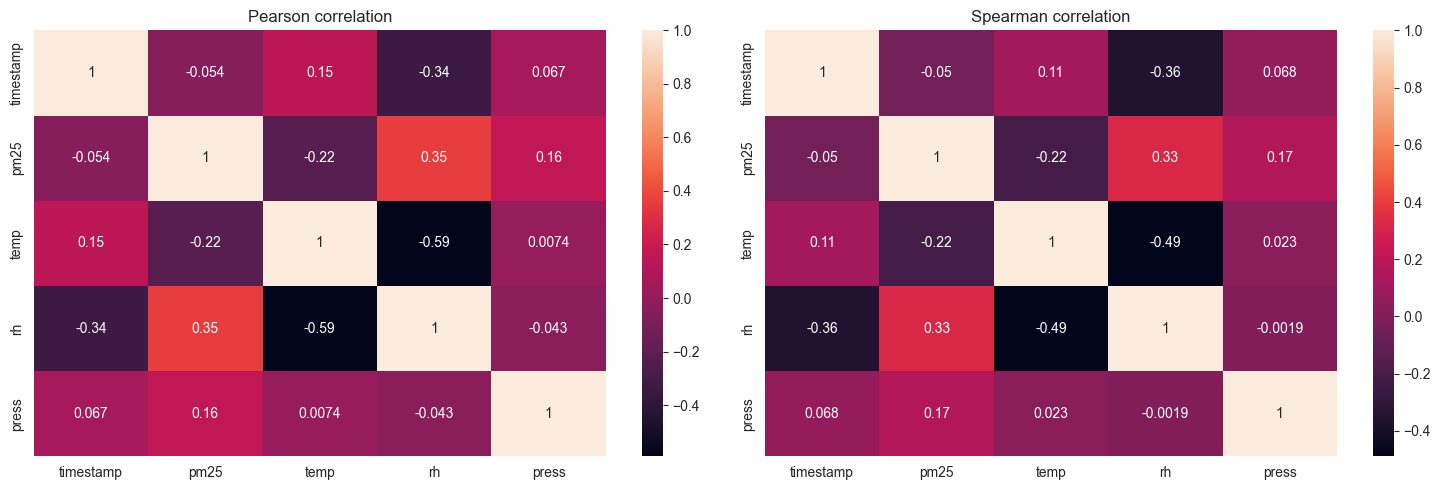

In [66]:
_, ax = plt.subplots(1,2, figsize = (15,5))

sns.heatmap(pearson_matrix, ax=ax[0], annot=True)
sns.heatmap(spearman_matrix, ax=ax[1], annot=True)
ax[0].set_title('Pearson correlation')
ax[1].set_title('Spearman correlation')

plt.tight_layout()
plt.show()

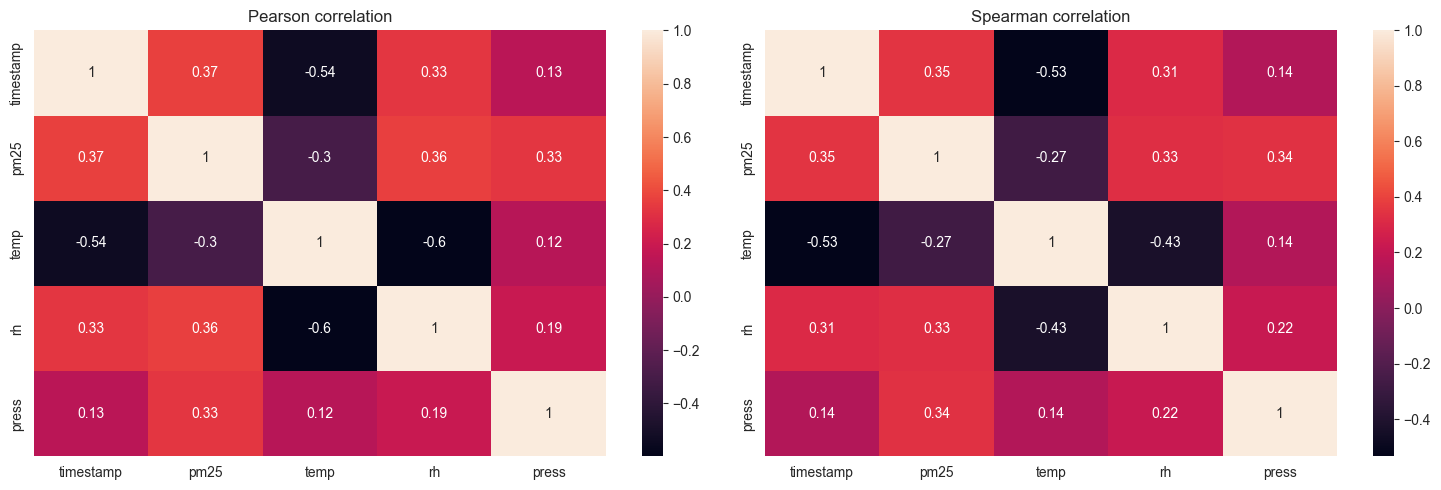

In [121]:
_, ax = plt.subplots(1,2, figsize = (15,5))

sns.heatmap(pearson_matrix, ax=ax[0], annot=True)
sns.heatmap(spearman_matrix, ax=ax[1], annot=True)
ax[0].set_title('Pearson correlation')
ax[1].set_title('Spearman correlation')

plt.tight_layout()
plt.show()

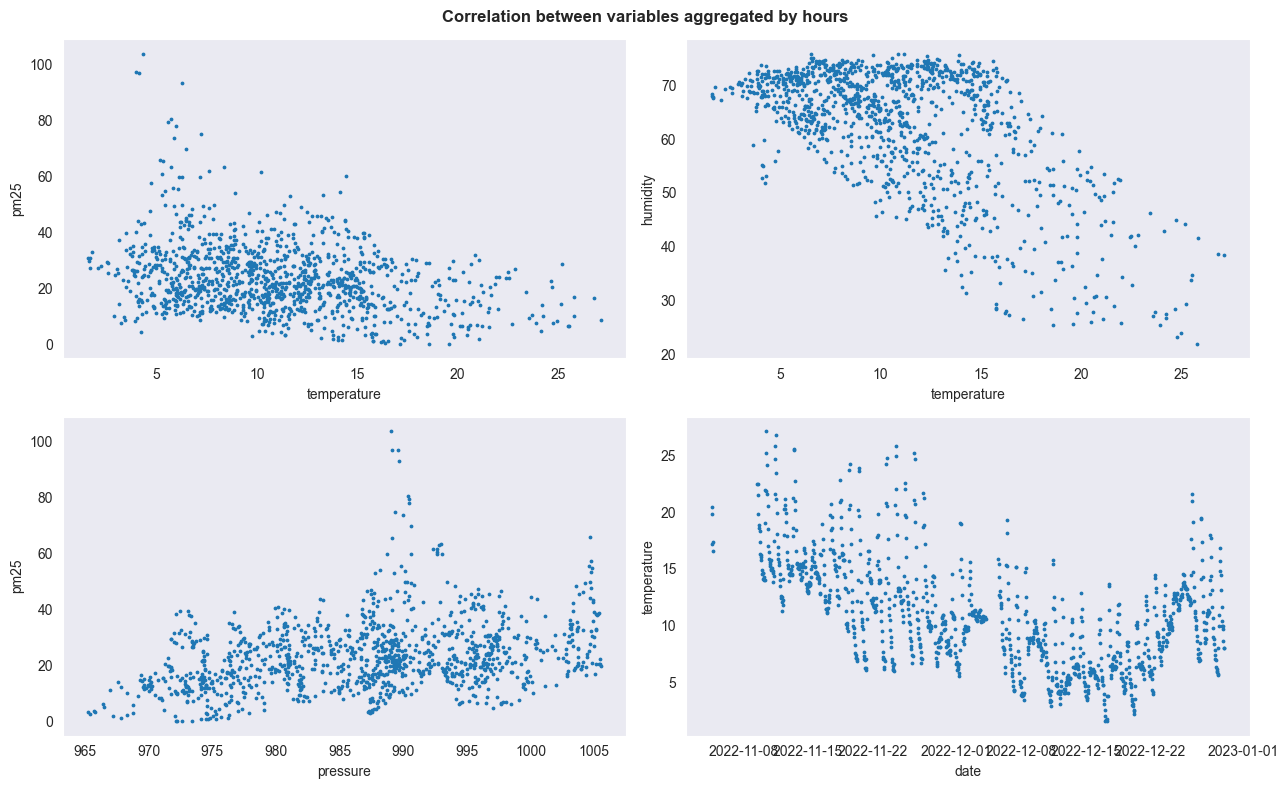

In [26]:
fig, ax = plt.subplots(2,2, figsize=(13, 8))

ax[0][0].scatter(df_completed_h['temp'], df_completed_h['pm25'], s=3)
ax[0][0].grid()
ax[0][0].set_xlabel('temperature')
ax[0][0].set_ylabel('pm25')

ax[0][1].scatter(df_completed_h['temp'], df_completed_h['rh'], s=3)
ax[0][1].grid()
ax[0][1].set_xlabel('temperature')
ax[0][1].set_ylabel('humidity')

ax[1][0].scatter(df_completed_h['press'], df_completed_h['pm25'], s=3)
ax[1][0].grid()
ax[1][0].set_xlabel('pressure')
ax[1][0].set_ylabel('pm25')

ax[1][1].scatter(df_completed_h['timestamp'], df_completed_h['temp'], s=3)
ax[1][1].grid()
ax[1][1].set_xlabel('date')
ax[1][1].set_ylabel('temperature')

fig.suptitle('Correlation between variables aggregated by hours', fontweight='bold')
plt.tight_layout()
plt.show()